# Set up
##Import libraries

In [ ]:
import pandas as pd
import json
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt

##Mount google drive and GCS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  49033      0 --:--:-- --:--:-- --:--:-- 49240
OK
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 11.0 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unsele

In [ ]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1721059210,"nanos":282007621},"severity":"INFO","message":"Start gcsfuse/2.3.1 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1721059210,"nanos":282212291},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier

In [ ]:
#test mounting
os.listdir(local_path)

['preprocessed-data', 'raw-data']

##Create output directory


In [ ]:
downsampled_path = f"{local_path}/raw-data/downsampled-data"
no_banner_path = f"{local_path}/raw-data/preprocessed_data"

# Create output directory if it doesn't exist
red_only_path = os.path.join(local_path, 'raw-data', 'preprocessed_data_red')
os.makedirs(red_only_path, exist_ok=True)

In [ ]:
#test makedir"
os.listdir(f"{local_path}/raw-data/")

['downsampled-data',
 'orinoquia-camera-traps',
 'preprocessed_data',
 'preprocessed_data_red']

#Extract red channel

##Test code with 2 images

Shape of monochrome image:  (1440, 1920, 3)
Shape of color image:  (1440, 1920, 3)


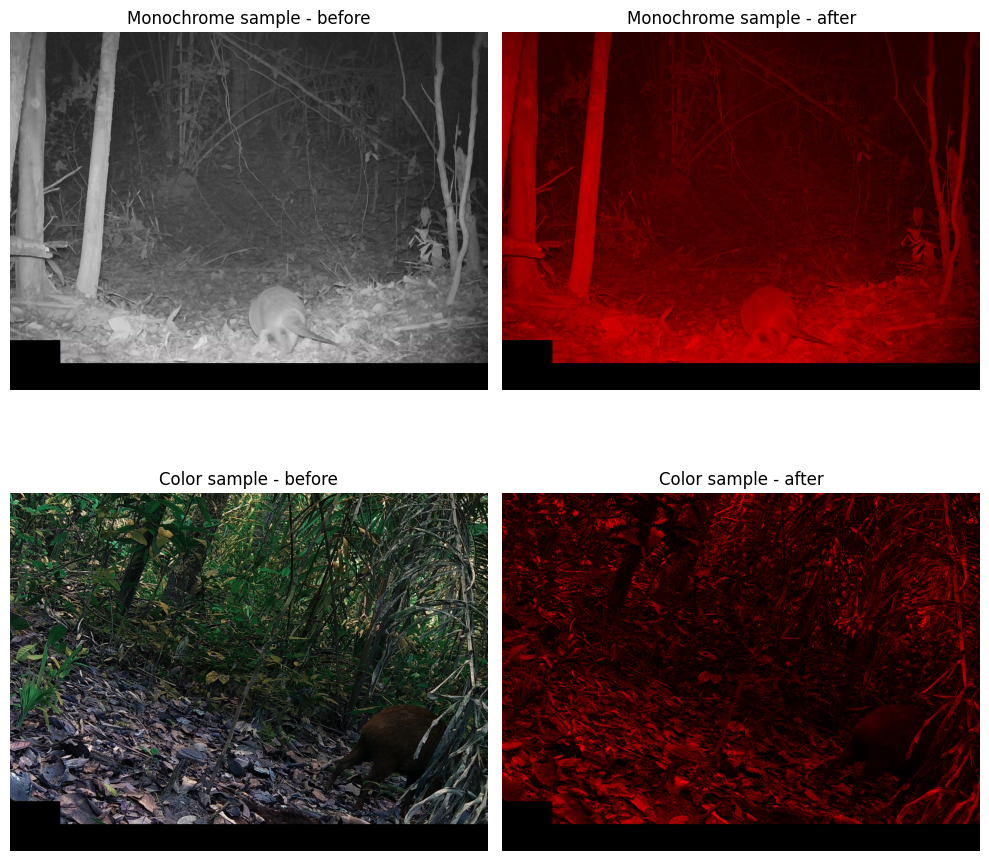

In [ ]:
#Get 2 images, one colored and one monochrome

img_mono =  plt.imread(f"{no_banner_path}/A06_100EK113_01130049.JPG")
img_color =  plt.imread(f"{no_banner_path}/N29_103EK113_03210009.JPG")

#check image shape
print("Shape of monochrome image: ", img_mono.shape)
print("Shape of color image: ", img_color.shape)

# Set blue and green channels to 0
img_mono_red = img_mono.copy()
img_mono_red[:,:,1] = 0
img_mono_red[:,:,2] = 0

img_color_red = img_color.copy()
img_color_red[:,:,1] = 0
img_color_red[:,:,2] = 0

#Visualize
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)
axs[0, 0].imshow(img_mono)
axs[0, 0].set_title("Monochrome sample - before")
axs[0, 0].axis("off")

axs[0, 1].imshow(img_mono_red)
axs[0, 1].set_title("Monochrome sample - after")
axs[0, 1].axis("off")

axs[1, 0].imshow(img_color)
axs[1, 0].set_title("Color sample - before")
axs[1, 0].axis("off")

axs[1, 1].imshow(img_color_red)
axs[1, 1].set_title("Color sample - after")
axs[1, 1].axis("off")

plt.show()

##Convert all images in folder to red only

In [ ]:
#check number of images
imageList = os.listdir(no_banner_path)
numImage = len(imageList)
print(numImage)

31836


In [ ]:
#initiate counter
processed_count = 0
existed_count = 0

#set input, output path
input_path = no_banner_path
output_path = red_only_path

#loop through all image files in input dir
for file in tqdm(os.listdir(input_path)):

    if file.endswith(".JPG"):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file)

        if os.path.exists(output_file):
            # print(f"Image {file} already exists in the output directory")
            existed_count+=1

        else:
            try:
                # Read image and create copy
                img = plt.imread(input_file)
                img_copy = img.copy()

                # Set blue and green channels of copy to 0
                img_copy[:,:,1] = 0
                img_copy[:,:,2] = 0

                # Save the processed image
                cv2.imwrite(output_file, img_copy)
                # print(f"Image {file} processed and saved to {output_path}")

                # Increment the image counter
                processed_count += 1

                # Break the loop when batch size reached
                if processed_count >= numImage:
                    break
            except Exception as e:
                print(f"Error processing image {file}: {e}")

100%|██████████| 31836/31836 [2:30:24<00:00,  3.53it/s]


In [ ]:
#counts check, should be input = output = processed+existed

print(f"Number of images in input directory: {len(os.listdir(input_path))}")
print(f"Number of images in output directory: {len(os.listdir(output_path))}")
print(f"Number of images processed + existed: {processed_count+existed_count}")
print(f"Number of images processed: {processed_count}")
print(f"Number of images already existed: {existed_count}")

Number of images in input directory: 31836
Number of images in output directory: 31836
Number of images processed + existed: 31836
Number of images processed: 19924
Number of images already existed: 11912


#Random sample check

Shape of original image:  (1440, 1920, 3)
Shape of processed image:  (1440, 1920, 3)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

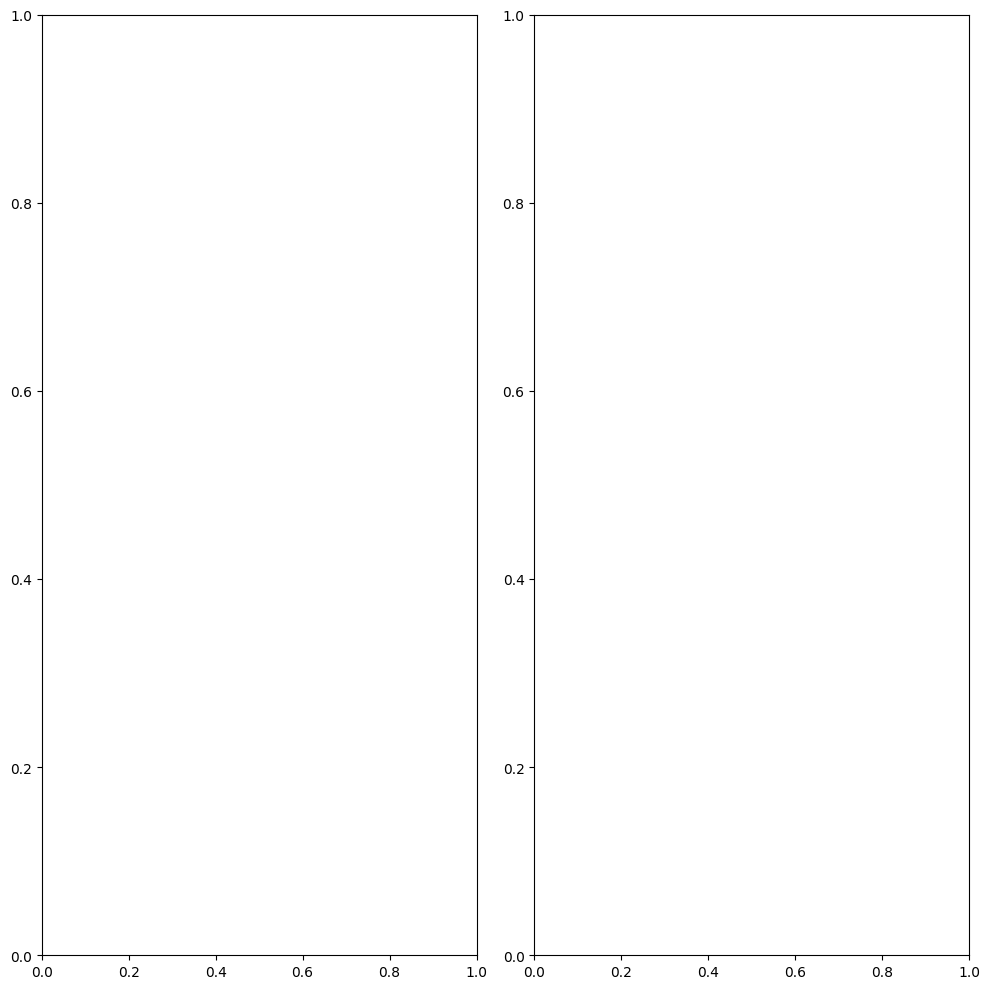

In [ ]:
# #get a random file name
# import random
# checkfile = random.choice(imageList)

# #read the image
# img_org =  plt.imread(f"{no_banner_path}/{checkfile}")
# img_red =  plt.imread(f"{red_only_path}/{checkfile}")

# #check image shape
# print("Shape of original image: ", img_org.shape)
# print("Shape of processed image: ", img_red.shape)

# #Visualize
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10), tight_layout=True)
# axs[0, 0].imshow(img_org)
# axs[0, 0].set_title("Before")
# axs[0, 0].axis("off")

# axs[0, 1].imshow(img_red)
# axs[0, 1].set_title("After")
# axs[0, 1].axis("off")

# plt.show()